In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Let's start by reading the data.

In [3]:
trials = pd.read_csv('trials.csv', index_col=0)
measurements = pd.read_csv('measurements.csv', index_col=0)

# Keep only some trials
tubes = measurements[measurements['trial_id'].isin([3])]
tubes

,trial_id,tube_id,start_time,end_time,weight_empty,weight_full,brix_percent,weight_before_dilution,weight_after_dilution,diluted_brix,notes
id,,,,,,,,,,,
40,3,1,0.000,25.674,6.50,7.22,NaN,7.10,7.70,17.0,Brix off scale for first few samples
41,3,2,25.793,28.107,6.60,6.87,NaN,6.80,7.06,13.3,NaN
42,3,3,28.226,30.679,6.48,6.78,NaN,6.71,7.02,14.1,NaN
43,3,4,30.797,33.407,6.62,7.15,NaN,7.14,7.65,18.0,NaN
44,3,5,33.525,36.311,6.59,7.23,NaN,7.21,7.89,16.0,NaN
45,3,6,36.429,39.416,6.36,7.49,NaN,7.50,8.63,14.9,NaN
46,3,7,39.535,42.751,6.70,8.37,28.4,8.26,10.30,14.2,NaN
47,3,8,42.869,46.353,6.57,9.05,23.1,8.89,11.26,11.4,NaN
48,3,9,46.472,50.268,6.60,10.25,18.3,10.10,13.63,10.3,Lots of liquid; difficult to mix after dilution


Let's take a look at TDS vs. time.

<ipython-input-4-d177d1d38500>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['start'] = np.concatenate([np.array([tubes['start_time'].values[0]]), split_times])
<ipython-input-4-d177d1d38500>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['end'] = np.concatenate([split_times, np.array([tubes['end_time'].values[-1]])])
<ipython-input-4-d177d1d38500>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

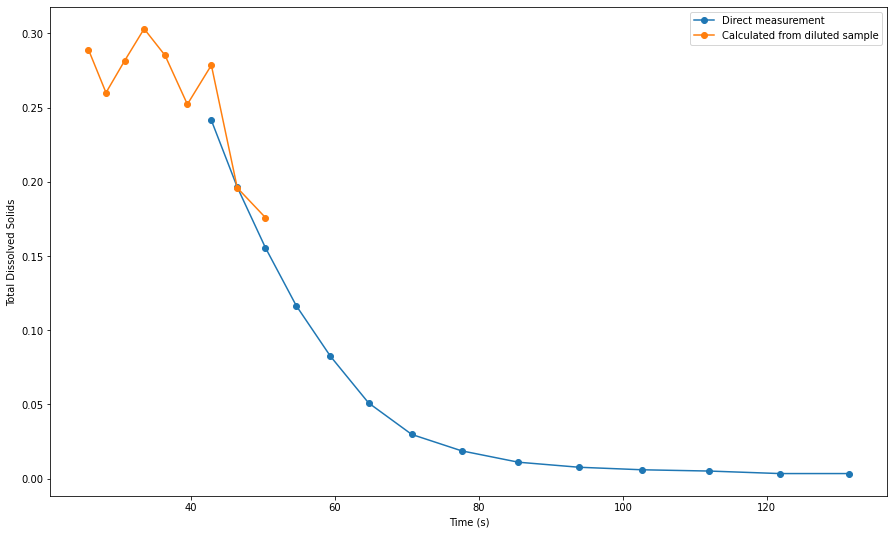

In [4]:
# Calculate split times
split_times = (tubes['end_time'].values[:-1] + tubes['start_time'].values[1:]) / 2.

tubes['start'] = np.concatenate([np.array([tubes['start_time'].values[0]]), split_times])
tubes['end'] = np.concatenate([split_times, np.array([tubes['end_time'].values[-1]])])

# Calculate Brix from diluted measurements
tubes['brix_from_dilution'] = (tubes['weight_after_dilution'] - tubes['weight_empty']) / (tubes['weight_before_dilution'] - tubes['weight_empty']) * tubes['diluted_brix']

# Now convert to TDS
tubes['tds'] = tubes['brix_percent'] * 0.85 / 100.
tubes['tds_from_dilution'] = tubes['brix_from_dilution'] * 0.85 / 100.

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Total Dissolved Solids')

# Plot TDS
ax.plot(tubes['end'], tubes['tds'], marker = 'o', label='Direct measurement')
ax.plot(tubes['end'], tubes['tds_from_dilution'], marker = 'o', label = 'Calculated from diluted sample')

# Add a legend to the plot
ax.legend()

Now let's calculate beverage weight vs. time.

<ipython-input-5-ce9aef30cb27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['liquid_weight'] = tubes['weight_full'] - tubes['weight_empty']
<ipython-input-5-ce9aef30cb27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['cumulative_weight'] = tubes['liquid_weight'].cumsum()


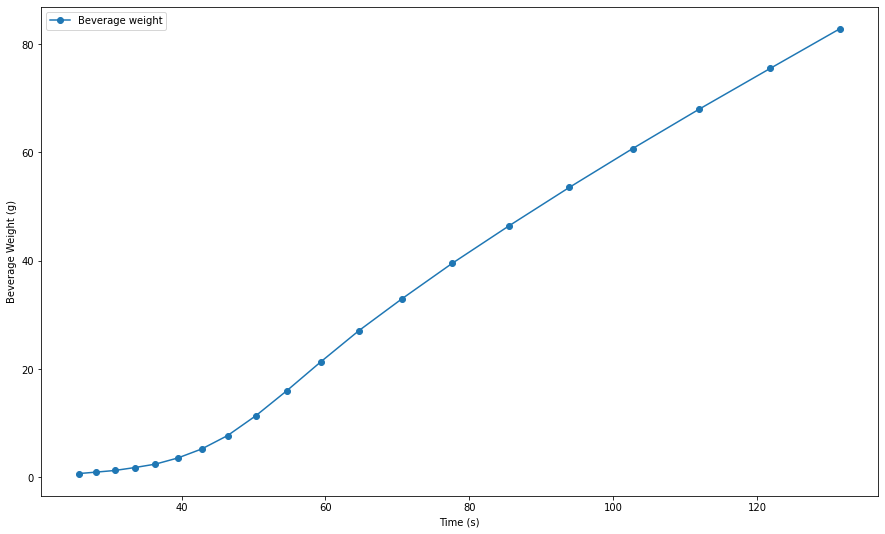

In [5]:
# Calculate beverage weight
tubes['liquid_weight'] = tubes['weight_full'] - tubes['weight_empty']
tubes['cumulative_weight'] = tubes['liquid_weight'].cumsum()

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Beverage Weight (g)')

# Plot Brix percent
ax.plot(tubes['end'], tubes['cumulative_weight'], marker='o', label='Beverage weight')

# Add a legend to the plot
ax.legend()

What is the slope on the right?

LinregressResult(slope=0.8860732156815476, intercept=-31.232311306269715, rvalue=0.9978608597214199, pvalue=2.1958281630477523e-14, stderr=0.017502719392169415, intercept_stderr=1.51749764184594)


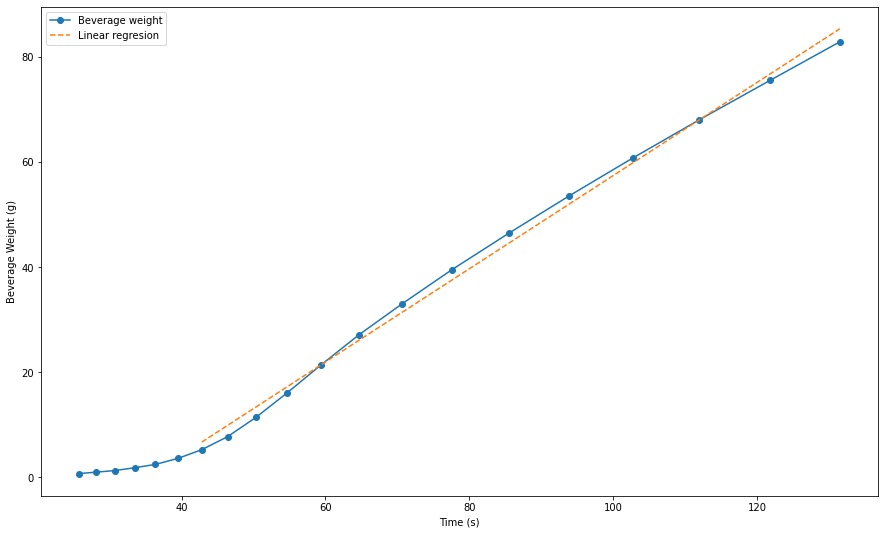

In [6]:
# Get right portion of plot
xs = tubes[tubes['tube_id'] >= 8]['end'].dropna()
ys = tubes[tubes['tube_id'] >= 8]['cumulative_weight'].dropna()

# Get linear regression
res = linregress(xs, ys)
print(res)

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Beverage Weight (g)')

# Plot beverage weight
ax.plot(tubes['end'], tubes['cumulative_weight'], marker='o', label='Beverage weight')

# Plot best fit
xs = np.linspace(tubes[tubes['tube_id'] == 8]['start'], tubes['end'].values[-1], 200)
ys = res.intercept + res.slope * xs
ax.plot(xs, ys, '--', label='Linear regresion')

# Add a legend to the plot
ax.legend()

We did lose some liquid to the funnel.

In [7]:
w_lost = trials['funnel_weight_after'][1] - trials['funnel_weight_before'][1]
w_lost

0.8099999999999987

Let's try splitting this according to flow rate. First we need to calculate flow rate:

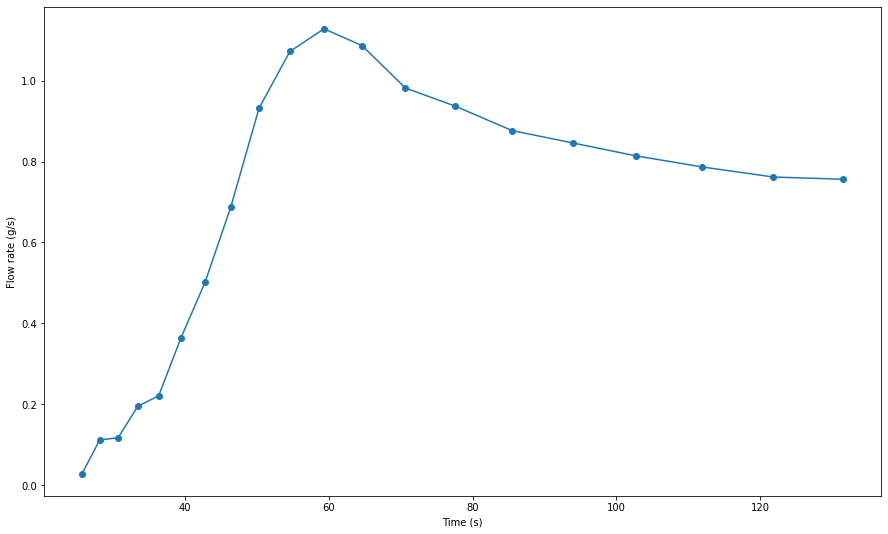

In [8]:
flow = tubes['liquid_weight'] / (tubes['end'] - tubes['start'])

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Flow rate (g/s)')

# Plot beverage weight
ax.plot(tubes['end'], flow, marker='o')

Now we need to split the missing weight according to the flow rate for each tube.

In [9]:
total_flow = flow.sum()
n = flow.dropna().count()

# Divide missing weight between tubes
tubes['adj_liquid_weight'] = tubes['weight_full'] - tubes['weight_empty'] + w_lost / n

# Recalculate cumulative weight
tubes['adj_cumulative_weight'] = tubes['adj_liquid_weight'].cumsum()

<ipython-input-9-4e64700d7ae7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['adj_liquid_weight'] = tubes['weight_full'] - tubes['weight_empty'] + w_lost / n
<ipython-input-9-4e64700d7ae7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['adj_cumulative_weight'] = tubes['adj_liquid_weight'].cumsum()


What is the maximum time for a single sample?

In [10]:
ts = tubes['end'].dropna().values
print(ts[1:] - ts[:-1])
print(np.max(ts[1:] - ts[:-1]))

[2.433  2.5715 2.728  2.904  3.1055 3.3345 3.6025 3.915  4.289  4.741
 5.3005 6.0085 6.937  7.882  8.427  8.7695 9.2685 9.8595 9.68  ]
9.859499999999997


This seems about right. With a flow rate of 2.4 g/s, a sample time of 3.3 seconds would give 7.92 g. Our test tubes have a specified capacity of 7 ml, which is probably a little lower than the point where they would overflow.

Now let's try sample TDS vs. brew ratio.

<ipython-input-11-1327dc7a901b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['br'] = tubes['cumulative_weight'] / weight_in
<ipython-input-11-1327dc7a901b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['adj_br'] = tubes['adj_cumulative_weight'] / weight_in


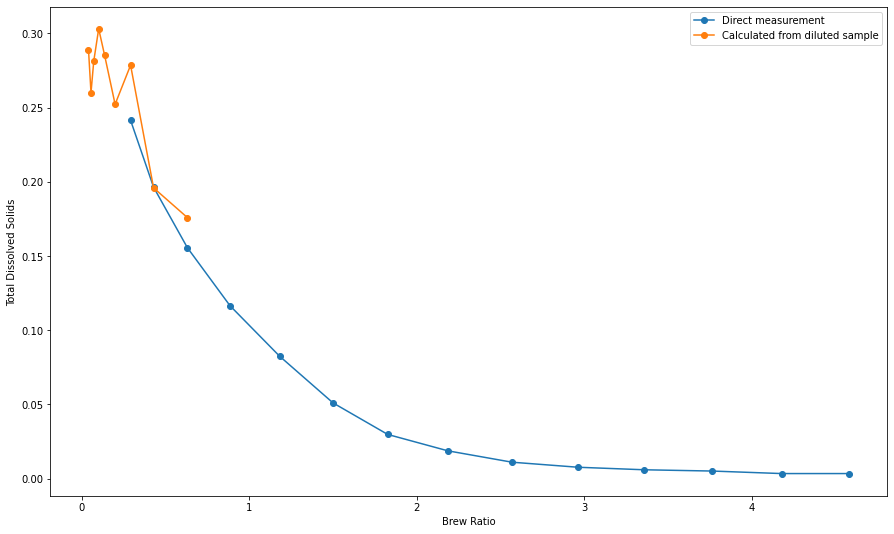

In [11]:
weight_in = trials['weight_in_basket'][1]
tubes['br'] = tubes['cumulative_weight'] / weight_in
tubes['adj_br'] = tubes['adj_cumulative_weight'] / weight_in

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

# Plot Brix percent
ax.plot(tubes['br'], tubes['tds'], marker='o', label='Direct measurement')
ax.plot(tubes['br'], tubes['tds_from_dilution'], marker='o', label='Calculated from diluted sample')

# Add a legend to the plot
ax.legend()

Now let's calculate EY.

<ipython-input-12-7c58e004f9a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['tds_filled'] = tubes['tds'].where(tubes['tds'].notna(), tubes['tds_from_dilution'])
<ipython-input-12-7c58e004f9a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tubes['dissolved_weight'] = tubes['tds_filled'] * tubes['liquid_weight']
<ipython-input-12-7c58e004f9a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

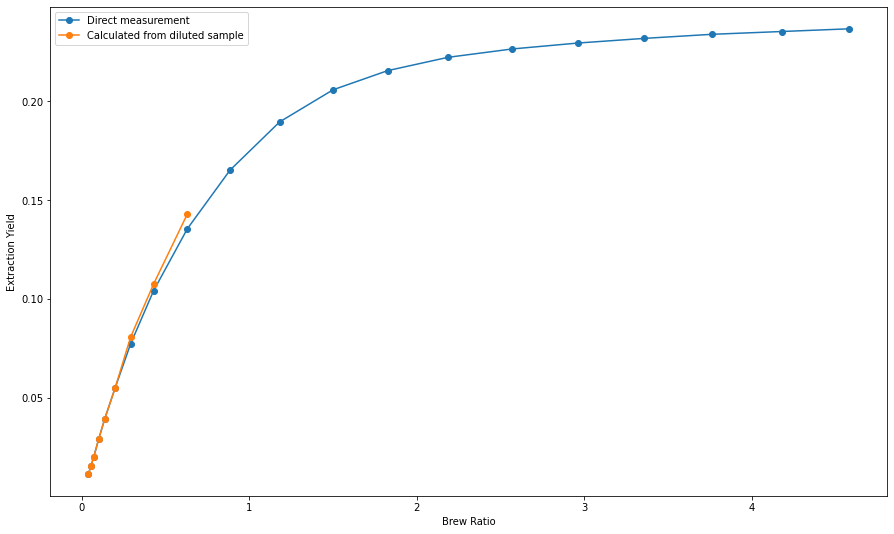

In [12]:
# Fill in missing data
tubes['tds_filled'] = tubes['tds'].where(tubes['tds'].notna(), tubes['tds_from_dilution'])

tubes['dissolved_weight'] = tubes['tds_filled'] * tubes['liquid_weight']
tubes['dissolved_weight_from_dilution'] = tubes['tds_from_dilution'] * tubes['liquid_weight']
tubes['adj_dissolved_weight'] = tubes['tds_filled'] * tubes['adj_liquid_weight']

tubes['cumulative_dissolved'] = tubes['dissolved_weight'].cumsum()
tubes['cumulative_dissolved_from_dilution'] = tubes['dissolved_weight_from_dilution'].cumsum()
tubes['adj_cumulative_dissolved'] = tubes['adj_dissolved_weight'].cumsum()

tubes['cumulative_tds'] = tubes['cumulative_dissolved'] / tubes['cumulative_weight']
tubes['cumulative_tds_from_dilution'] = tubes['cumulative_dissolved_from_dilution'] / tubes['cumulative_weight']
tubes['adj_cumulative_tds'] = tubes['adj_cumulative_dissolved'] / tubes['adj_cumulative_weight']

tubes['ey'] = tubes['cumulative_dissolved'] / weight_in
tubes['ey_from_dilution'] = tubes['cumulative_dissolved_from_dilution'] / weight_in
tubes['adj_ey'] = tubes['adj_cumulative_dissolved'] / weight_in

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Plot Brix percent
ax.plot(tubes['br'], tubes['ey'], marker='o', label='Direct measurement')
ax.plot(tubes['br'], tubes['ey_from_dilution'], marker='o', label='Calculated from diluted sample')

# Add a legend to the plot
ax.legend()

Can we fit this with an exponential?

In [13]:
def get_error_exp(theta):
    m, tau = theta
    model_ey = m * (1 - np.exp(-tubes['br'][:-1] / tau))
    return sum((tubes['ey'][:-1] - model_ey)**2)

theta = np.array([1., 1.])
soln = minimize(get_error_exp, theta)
print(soln)

      fun: 1.9372610947473537e-05
 hess_inv: array([[ 0.10813522,  0.79123185],
       [ 0.79123185, 12.00682389]])
      jac: array([-5.16493719e-06,  1.87537808e-08])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 12
     njev: 18
   status: 0
  success: True
        x: array([0.23484381, 0.73245649])


That looks like a pretty good fit. Let's plot it.

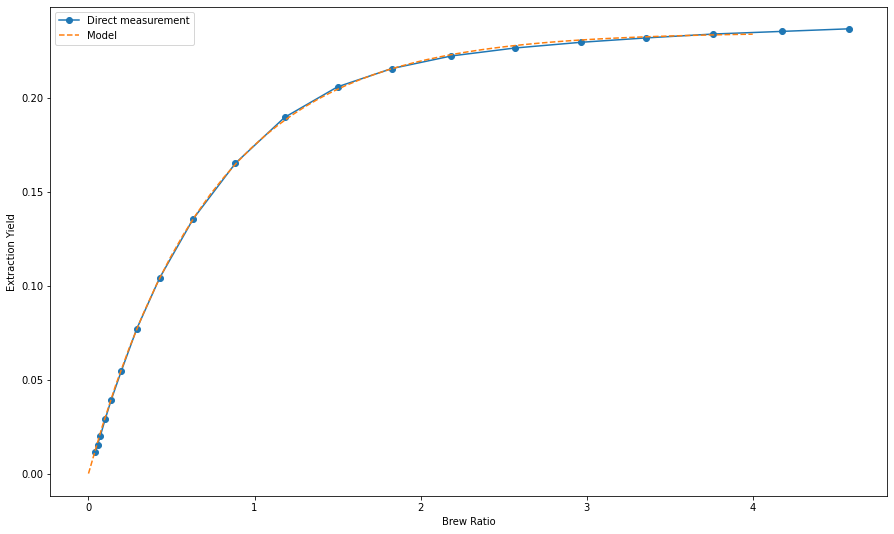

In [14]:
# Get fit curve
m, tau = soln.x
xs = np.linspace(0., 4.)
ys = m * (1 - np.exp(-xs / tau))

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Plot Brix percent
ax.plot(tubes['br'], tubes['ey'], marker='o', label='Direct measurement')
ax.plot(xs, ys, '--', label='Model')

# Add a legend to the plot
ax.legend()

It's possible the extraction process just doesn't fit this model, but given that we later see that the Salamibot data seems to "creep forward" toward the end instead of settling on a final EY, the plot above seems to support that hypothesis--i.e., it looks like some of the extraction from earlier in the shot is being carried forward to later parts of the shot.

How about cumulative TDS vs. brew ratio?

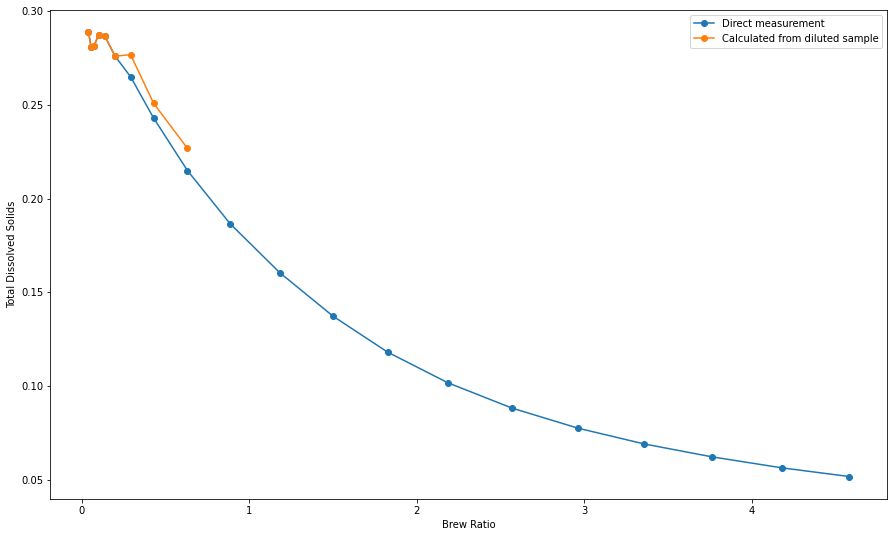

In [15]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

# Plot Brix percent
ax.plot(tubes['br'], tubes['cumulative_tds'], marker='o', label='Direct measurement')
ax.plot(tubes['br'], tubes['cumulative_tds_from_dilution'], marker='o', label='Calculated from diluted sample')

# Add a legend to the plot
ax.legend()

And finally TDS vs. EY.

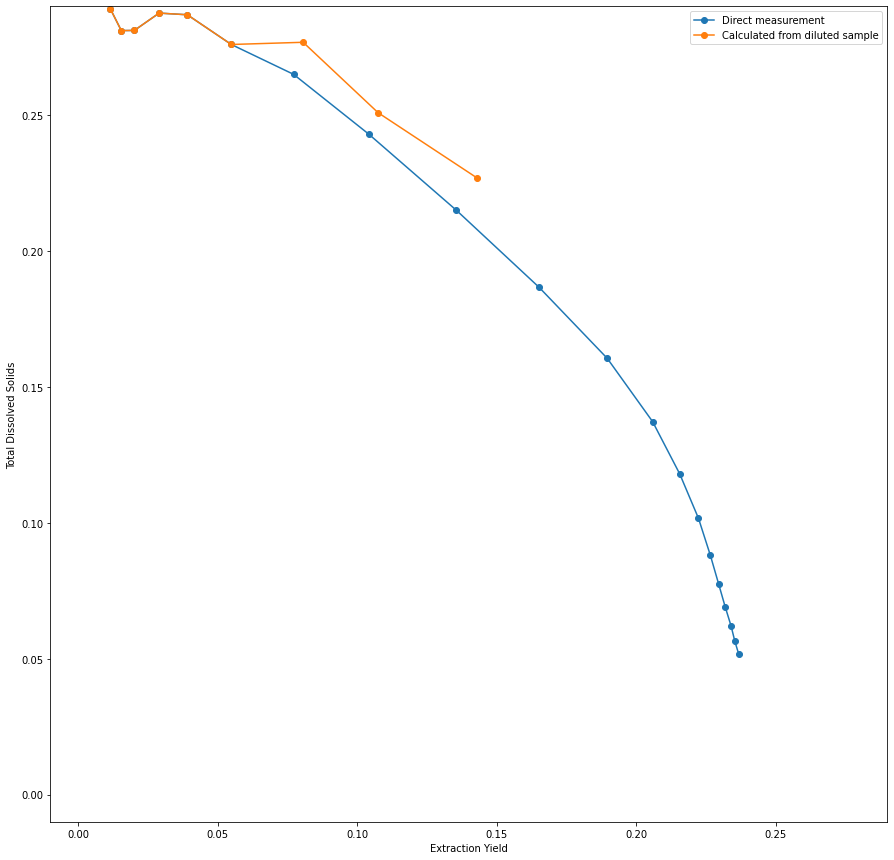

In [16]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,15))

# Set axis limits
plt.xlim((-0.01, 0.29))
plt.ylim((-0.01, 0.29))

# Label the axes
ax.set_xlabel('Extraction Yield')
ax.set_ylabel('Total Dissolved Solids')

# Plot Brix percent
ax.plot(tubes['ey'], tubes['cumulative_tds'], marker='o', label='Direct measurement')
ax.plot(tubes['ey_from_dilution'], tubes['cumulative_tds_from_dilution'], marker='o', label='Calculated from diluted sample')

# Add a legend to the plot
ax.legend()

Let's compare with the same gathered by splitting shots.

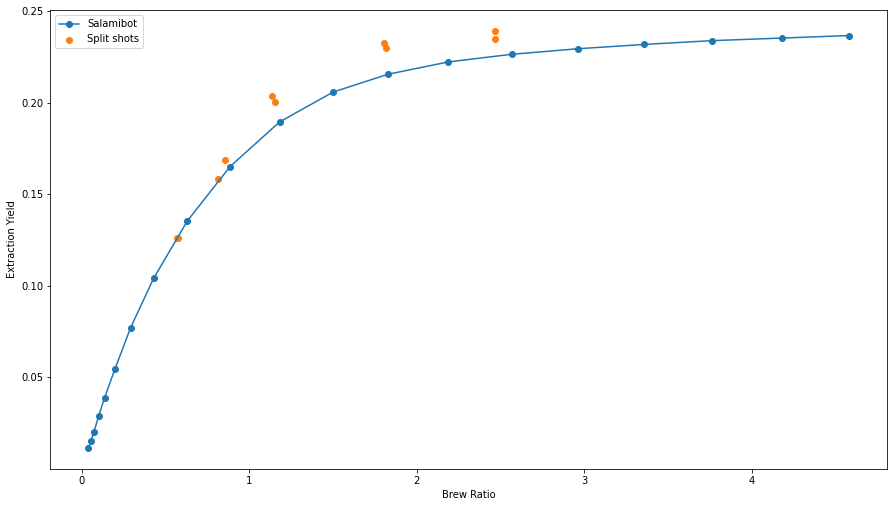

In [17]:
# Load shots table
shots = pd.read_excel('../../../database.xlsx', sheet_name='shots', header=0, index_col=0)

# Keep only certain trials
trials_to_keep = [12]
#trials_to_keep = [15]
shots = shots[shots['trial_id'].isin(trials_to_keep)]

# Complete split data with full data
shots['split_weight'] = shots['split_weight'].fillna(shots['weight_in_cup'])
shots['split_brix'] = shots['split_brix'].fillna(shots['brix_percent'])

# Ignore shots with no Brix measurement
shots = shots.dropna(subset=['weight_in_basket'])
shots = shots.dropna(subset=['split_brix'])

# Calculate TDS, EY, and brew ratio
shots['tds'] = shots['split_brix'] / 100. * 0.85
shots['ey'] = shots['tds'] * shots['split_weight'] / shots['weight_in_basket']
shots['brew_ratio'] = shots['split_weight'] / shots['weight_in_basket']

# Create the figure
fig, ax = plt.subplots(figsize=(15,15/1920*1080))
fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Plot Salamibot data
ax.plot(tubes['br'], tubes['ey'], marker='o', label='Salamibot', color='C0')
#ax.plot(tubes['adj_br'], tubes['adj_ey'], label='Salamibot adjusted', color='C0')

# Plot split shot data
ax.scatter(shots['brew_ratio'], shots['ey'], label='Split shots', color='C1')

# Add a legend to the plot
ax.legend()

These differences might be due to instrument error. Although it seems like the TDS measurements are similar, and therefore the systematic error should be as well, in reality the raw Salamibot measurements are quite different:

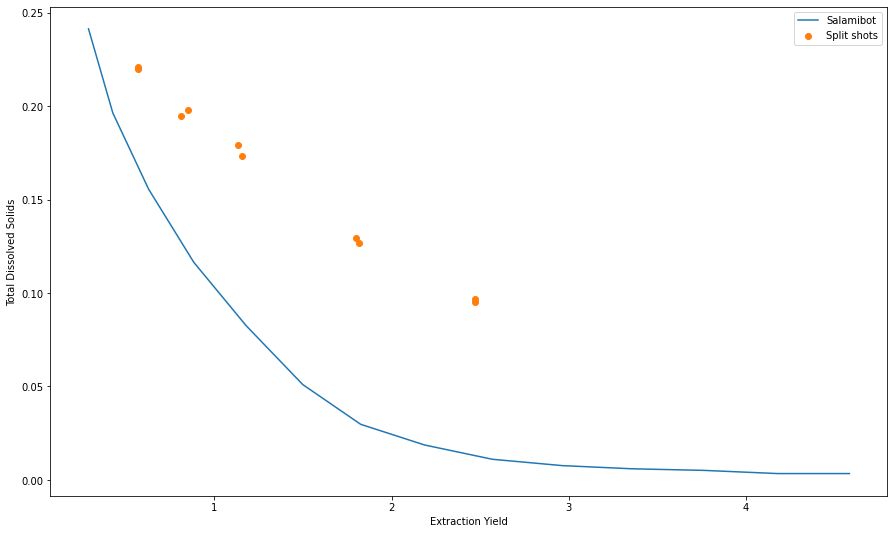

In [18]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Extraction Yield')
ax.set_ylabel('Total Dissolved Solids')

# Plot Salamibot data
ax.plot(tubes['br'], tubes['tds'], label='Salamibot', color='C0')

# Plot split shot data
ax.scatter(shots['brew_ratio'], shots['tds'], label='Split shots', color='C1')

# Add a legend to the plot
ax.legend()

Can we use optimization to find a 3-point "instrument error" function which brings these data sets into alignment? If so, and if the hypothetical instrument errors are within spec for the refractometer, it might suggest that this is the cause of the discrepancy.

In [19]:
def get_corrected_tds(theta, tds):
    return tds + theta[1] * tds**2 + theta[0] * tds

def get_error(theta):
    c_salami_tds = get_corrected_tds(theta, tubes['tds'])
    c_shot_tds = get_corrected_tds(theta, shots['tds'])
    #c_shot_tds = shots['tds']

    c_dissolved_weight = c_salami_tds * tubes['liquid_weight']
    c_cumulative_dissolved = c_dissolved_weight.cumsum()
    c_cumulative_tds = c_cumulative_dissolved / tubes['cumulative_weight']
    
    f = interp1d(tubes['br'], c_cumulative_tds)
    split_tds_interp = f(shots['brew_ratio'])
    return sum(((c_shot_tds - split_tds_interp) / split_tds_interp)**2)

theta = np.array([0., 0.])
print(get_error(theta))

soln = minimize(get_error, theta)
print(soln)

3.0969610751731858
      fun: 2.044520179177788
 hess_inv: array([[ 0.5481959 , -2.08988631],
       [-2.08988631,  8.38695478]])
      jac: array([-8.94069672e-08, -1.49011612e-07])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 4
     njev: 11
   status: 0
  success: True
        x: array([-1.67518260e-03, -3.88636436e+00])


Let's see what this looks like.

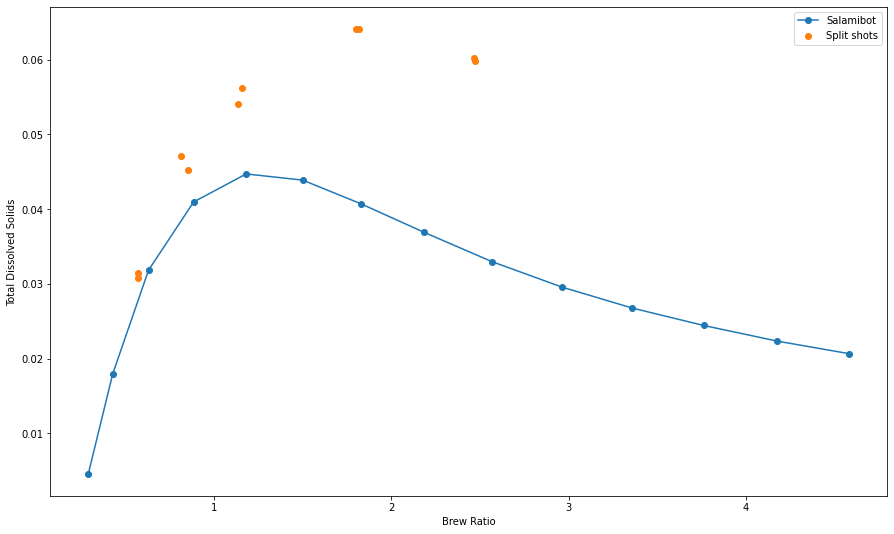

In [20]:
# Get corrected TDS
theta = soln.x

c_salami_tds = get_corrected_tds(theta, tubes['tds'])
c_shot_tds = get_corrected_tds(theta, shots['tds'])
#c_shot_tds = shots['tds']

c_dissolved_weight = c_salami_tds * tubes['liquid_weight']
c_cumulative_dissolved = c_dissolved_weight.cumsum()
c_cumulative_tds = c_cumulative_dissolved / tubes['cumulative_weight']
c_ey = c_cumulative_dissolved / weight_in

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

# Plot Salamibot data
ax.plot(tubes['br'], c_cumulative_tds, label='Salamibot', marker='o', color='C0')

# Plot split shot data
ax.scatter(shots['brew_ratio'], c_shot_tds, label='Split shots', color='C1')

# Add a legend to the plot
ax.legend()

And TDS vs. EY:

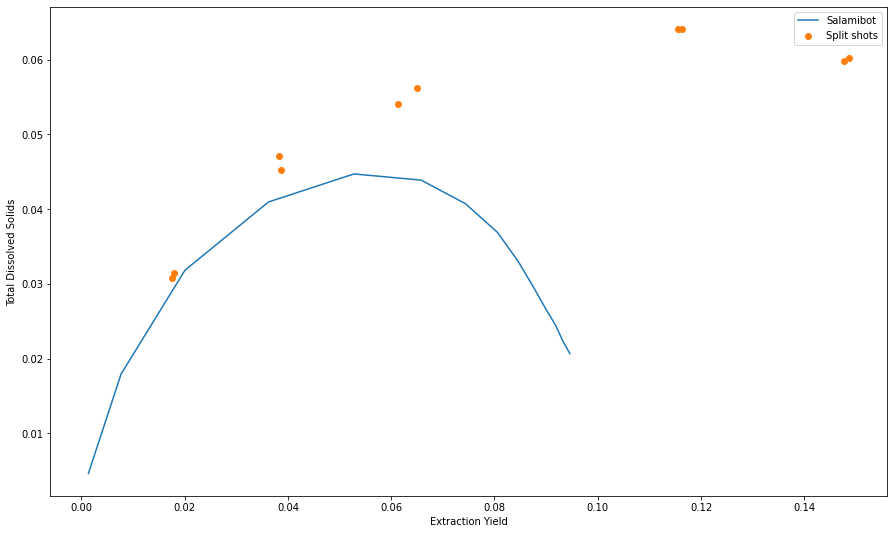

In [21]:
c_shot_ey = shots['brew_ratio'] * c_shot_tds

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Extraction Yield')
ax.set_ylabel('Total Dissolved Solids')

# Plot Salamibot data
ax.plot(c_ey, c_cumulative_tds, label='Salamibot', color='C0')

# Plot split shot data
ax.scatter(c_shot_ey, c_shot_tds, label='Split shots', color='C1')

# Add a legend to the plot
ax.legend()

What does the correction function look like?

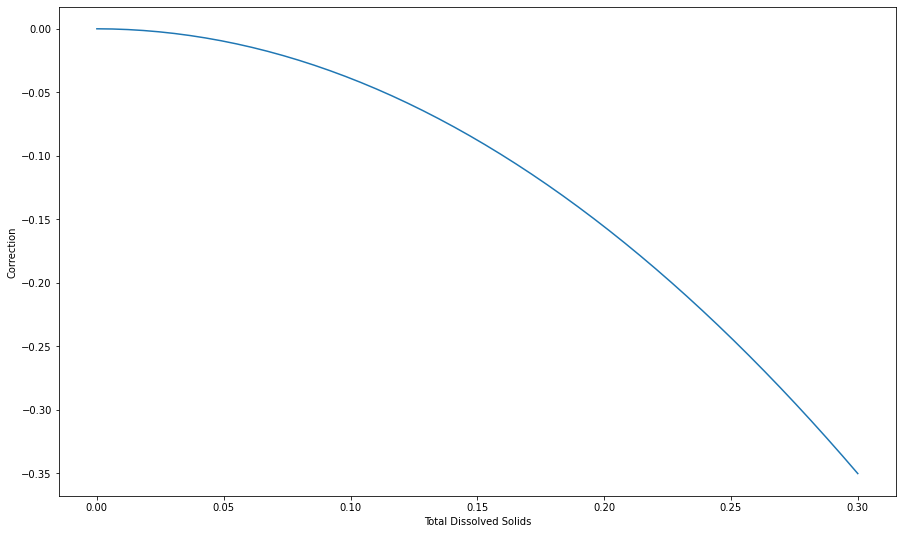

In [22]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Total Dissolved Solids')
ax.set_ylabel('Correction')

# Plot Salamibot data
xs = np.linspace(0., 0.30)
ys = get_corrected_tds(theta, xs) - xs
ax.plot(xs, ys)

(0.0, 0.315)

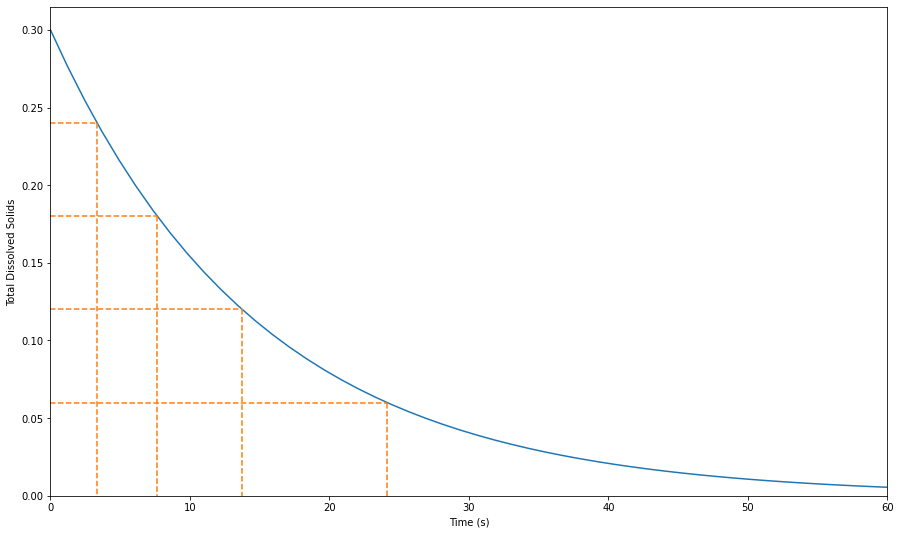

In [23]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Total Dissolved Solids')

# Plot Salamibot data
xs = np.linspace(0., 60.)
ys = 0.30 * np.exp(-xs / 15.)
ax.plot(xs, ys)

# Plot sample lines
N = 5
for i in range(1, N):
    y = 0.30 * (1 - i / N)
    x = -15. * np.log(y / 0.30)
    ax.plot([0, x], [y, y], '--', color='C1')
    ax.plot([x, x], [y, 0], '--', color='C1')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_xlim(0., 60.)
ax.set_ylim(0., ylim[1])